In [5]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [33]:
import kagglehub

dataDir = kagglehub.dataset_download("msambare/fer2013")
print("Ruta del dataset:", dataDir)


Ruta del dataset: C:\Users\Guill\.cache\kagglehub\datasets\msambare\fer2013\versions\1


In [ ]:
img_size = (48, 48)
batch_size = 32
dataDir = "dataset"

original_train_ds = tf.keras.utils.image_dataset_from_directory(
    dataDir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(48, 48),
    color_mode="grayscale",
    batch_size=32
)

class_names = original_train_ds.class_names  # ✅ Guardamos esto

# Luego aplicas normalización y prefetch
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = original_train_ds.map(lambda x, y: (normalization_layer(x), y))

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataDir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    color_mode="grayscale",
    batch_size=batch_size
)

Found 8271 files belonging to 4 classes.
Using 6617 files for training.
Found 8271 files belonging to 4 classes.
Using 1654 files for validation.


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [21]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# 🔄 Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Aplica data augmentation al dataset de entrenamiento
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

# 🧠 Modelo CNN con regularización L2
model = models.Sequential([
    layers.Input(shape=(48, 48, 1)),  # imágenes en escala de grises
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # ✅ L2 regularization
    layers.Dense(len(class_names), activation='softmax')  # salida multicategoría
])

# ⚙️ Compilación
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ⏹️ EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 🏋️ Entrenamiento
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop]
)


Epoch 1/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.4697 - loss: 1.3996 - val_accuracy: 0.6004 - val_loss: 75.2870
Epoch 2/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.5617 - loss: 0.9702 - val_accuracy: 0.6330 - val_loss: 51.5319
Epoch 3/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.5924 - loss: 0.9129 - val_accuracy: 0.5925 - val_loss: 37.8957
Epoch 4/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.6107 - loss: 0.8832 - val_accuracy: 0.6499 - val_loss: 56.5248
Epoch 5/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.6257 - loss: 0.8699 - val_accuracy: 0.6723 - val_loss: 42.8016
Epoch 6/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.6358 - loss: 0.8468 - val_accuracy: 0.7025 - val_loss: 39.4012


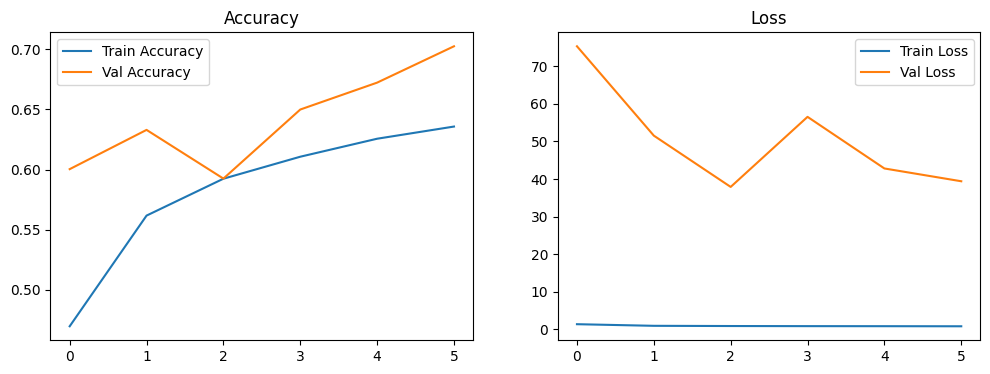

In [22]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


In [25]:
model.save("emotion_model.h5")

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

# Cargar modelo entrenado
model = tf.keras.models.load_model("emotion_model.h5")
class_names = ['angry', 'happy', 'sad', 'surprised', 'neutral']  # ajusta según tu dataset

# Cargar clasificador Haar para detección de rostros
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Iniciar cámara
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_resized = cv2.resize(roi_gray, (48, 48))
        roi_normalized = roi_resized / 255.0
        roi_reshaped = roi_normalized.reshape(1, 48, 48, 1)

        prediction = model.predict(roi_reshaped)
        emotion = class_names[np.argmax(prediction)]

        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    cv2.imshow('Detección de emociones', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

: 